<h1>Proiect: Tabelare și data visualizatio

Student: Guliciuc George Gabriel

Grupa: mDM11

Context:

    Este deja cunoscut că mărimea și zona în care se află  influnteaza prețul unui apartament, prin acest proiect doresc să văd dacă există o relație între prețul apartamentul și alte specificații a acestuia (anul construcției, etajul la care se află apartamentul, înălțimea blocului, tipul de încălzirea, dacă are un loc de parcare/garaj) în zona metropolitană Iași.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.formula.api import ols
from Functionalitati import *

<h2>Prezentarea bazei de date inițiale</h2>

Pentru acest proiect am extras datele de la anuturile de vânzare din zona metropolitană Iași de pe situl https://www.storia.ro/ro/rezultate/vanzare/apartament/iasi. Folosind un proces de data scraping, algoritmul se afla in fisierul "DataScraping.py". Datele extrase au fost salvate in fisierul "apartamente_de_vanzare.xlsx".

Am ales să folosesc datele doar acest site deoarece majoritatea anunțurilor se repetau și pe celalalte situri.

In [2]:
vanzare_df = pd.read_excel("apartamente_de_vanzare.xlsx")
inchiriere_df = pd.read_excel("apartamente_de_inchiriat.xlsx")

Baza de date inițială conține mai multe coloane, majoritatea nu ne sunt utile pentru acest proiect și o să fie eliminate. De asemenea toate datele sunt de tipul "strîng/text"(Python o sa foloseaca tipul "object" pt string https://stackoverflow.com/questions/21018654/strings-in-a-dataframe-but-dtype-is-object ), mai putin coloana "Numărul de camere" care este "int/numar" 

In [3]:
vanzare_df.dtypes

Zona                       object
Pret                       object
Suprafață                  object
Forma de proprietate       object
Numărul de camere           int64
Stare                      object
Etaj                       object
Balcon/grădină/terasă      object
Chirie                     object
Garaj/loc de parcare       object
Vizionare la distanță      object
Încălzire                  object
Tip proprietate            object
Tip vânzător               object
Liber de la                object
Anul construcției          object
Tip clădire                object
Tip geamuri                object
Lift                       object
Media                      object
Siguranță                  object
Facilități                 object
Informații suplimentare    object
Material de construcție    object
Titlu                      object
Descriere                  object
dtype: object

<h3> Din baza inițială o să salvăm următoarele coloane:</h3>

- Zona: Specifică locul unde se afla blocul;

- Pret: Prețul apartamentului în euro (sunt câteva cazuri în care este în RON);

- Suprafață: Suprafață utilă în m²;

- Garaj/loc de parcare: Garaj/loc de parcare sau câmp gol

- Încălzire: Modul de încălzirea a apartamentului sau câmp gol

- Anul construcției: Anul în care lucrările au fost finalizate

<h3> Note: </h3> O să ne folosim și de coloana "Descriere" pentru a completă câmpurile goale. În multe anunțuri unde anumite câmpuri sunt goale( ex: "Etaj")informațiile care ar trebui să umple respectivele câmpuri se pot găsi în "Descriere".

<h2> Operațiuni preliminare </h2>
<h3> Note: </h3>
Pentru nu a încarcă acest fișier, funcțiile folosite au fost scrise în fișierul "Functionalitati.py".

<h3>Câmpurile goale:</h3>
În datele inițiale intrările goale sunt "umplute"  cu "Cere informații" și "fără informații", pentru a nu există 2 lucruri care de fapt reprezintă același lucru le-am înlocuit cu NaN

In [4]:
vanzare_df.replace("Cere informații", np.nan, inplace=True)
vanzare_df.replace("fără informații", np.nan, inplace=True)

In [5]:
# inchiriere_df.replace("Cere informații", np.nan, inplace=True)
# inchiriere_df.replace("fără informații", np.nan, inplace=True)

<h3> Coloana "Zona Oras": (Categoric) </h3>
Am creat o nouă coloana "Zona oraș" din coloana "Zona", o salvăm doar cartierul unde se găsește apartamentul(ex: Podu Roș, Copou), în timp ce în în coloana "Zona" se găsesc mai multe informații: cartier, localitate, județ ( în unele cazuri fiind și stradă) dar pentru că ne raportăm doar la zona metropolitană Iași nu avem nevoie de localitate și județ și am luat stradă că acesta nu se găsește la majoritatea datelor.

In [6]:
vanzare_df['Zona'].head(10)

0                                 Podu Ros, Iasi, Iasi
1                                    Dacia, Iasi, Iasi
2                             Podu de Fier, Iasi, Iasi
3                                Agronomie, Iasi, Iasi
4                    Soseaua Nicolina, CUG, Iasi, Iasi
5                  Strada Voinesti, Galata, Iasi, Iasi
6                                 Podu Ros, Iasi, Iasi
7      Strada Moara de Vant, Moara de Vant, Iasi, Iasi
8    Strada Sfantul Ioan, Zona Industriala, Iasi, Iasi
9              Bulevardul Tutora, Podu Ros, Iasi, Iasi
Name: Zona, dtype: object

In [7]:
vanzare_df['Zona Oras'] = vanzare_df['Zona'].apply(city_zone)
# inchiriere_df['Zona Oras'] = inchiriere_df['Zona'].apply(city_zone)

In [8]:
vanzare_df['Zona Oras'].head(10)

0            Podu Ros
1               Dacia
2        Podu de Fier
3           Agronomie
4                 CUG
5              Galata
6            Podu Ros
7       Moara de Vant
8    Zona Industriala
9            Podu Ros
Name: Zona Oras, dtype: object

<h3> Coloana "Pret": (Numeric)</h3>

Această coloana conține valoarea apartamentului în euro, în baza de date originală prețul este un strîng, că să îl putem transformă în valoare numerică vom fi nevoiți să:

- să eliminăm caracterul "€"

- să eliminăm spațiile

Note: În cazul prețurilor în "RON" ele o să fie convertite în euro, am folosit rată de schimb 5 RON = 1 Euro

mean = 88130.68: Valoarea medie a unui apartament este 88130.68 euro.

deviatia standard = 52080.26: Abaterea de pretul mediu este 52080.26.

median = 78291.5: 50% din apartamente is valoreaza mai putin de 78291.5.

mode = 75000: Cel mai des un apartament valoreaza 75000.

Quartila 1 = 61200: 25% din apartamente valoreaza sub 61200.

Quartila 2 = 78291.5: 50% din apartamente valoreaza sub 78291.5.

Qyartila 3 = 100000: 75% din apartamente valoreaza sub 100000.

Coeficientul de asimetrie Person(Skewness) = 5.638764909574008: arata ca distributia este asimetrica la dreapta.

Coeficientul de boltire Fisher(Kurtosis) = 70.6089638591332:

Valorile sunt în intervalul închis [4634, 1192500].

In [9]:
vanzare_df['Pret'].head()

0    168 000 €
1    128 000 €
2    396 000 €
3    102 405 €
4    120 000 €
Name: Pret, dtype: object

In [10]:
vanzare_df['Pret'] = vanzare_df['Pret'].apply(convert_money)
# inchiriere_df['Pret'] = inchiriere_df['Pret'].apply(convert_money)

In [11]:
vanzare_df['Pret'].head()

0    168000
1    128000
2    396000
3    102405
4    120000
Name: Pret, dtype: int64

In [12]:
f"The mean of the pret is {vanzare_df['Pret'].mean()}"

'The mean of the pret is 91937.26648841354'

In [13]:
f"The median of the pret is {vanzare_df['Pret'].median()}"

'The median of the pret is 78000.0'

In [14]:
f"The mode of the pret is {st.mode(vanzare_df['Pret'])[0]}"

'The mode of the pret is 75000'

In [15]:
f"The kurtosis of the pret is {st.kurtosis(vanzare_df['Pret'])}"

'The kurtosis of the pret is 1347.4770168041457'

In [16]:
f"The skewness of the pret is {st.skew(vanzare_df['Pret'])}"

'The skewness of the pret is 34.9901569975624'

In [17]:
vanzare_df['Pret'].describe()

count    4.488000e+03
mean     9.193727e+04
std      1.776529e+05
min      4.634000e+03
25%      6.090000e+04
50%      7.800000e+04
75%      1.000000e+05
max      7.749250e+06
Name: Pret, dtype: float64

<h3> Coloana "Suprafață":(Numeric)</h3>

Această coloana conține suprafață apartamentului exprimată în m², în baza de dată originală  suprafață este un strîng, că să îl putem transformă în valoare numerică vom nevoiți să:

- să eliminăm caracterul "m²"

- să eliminăm spațiile
- să schimbăm caracterul "," cu "."

mean = 59.168838: Suprafata medie a unui apartament este 59.168838 m².

std (deviatia standard) = 26.230872 Abaterea de la suprafata medie este de 26.230872 m².

median = 55 50% din apartamente au o suprafata mai mare de 55.0 m².

mode = 50 Cea mai frecventa suprafata a unui apartament este de 50 m².

Quartila 1 = 45.000000 25% din apartamente au sub 45 m².

Quartila 2 = 55.000000 50% din apartamente au sub 55 m².

Qyartila 3 = 68.000000 75% din apartamente au sub 68 m².

Coeficientul de asimetrie Person(Skewness) = 4.544307691806732 arata ca distributia este asimetrica la dreapta.

Coeficientul de boltire Fisher(Kurtosis) = 44.925070367255515

Valorile sunt în intervalul închis [10, 506]

In [18]:
vanzare_df['Suprafață'].head()

0    66,18 m²
1       81 m²
2      230 m²
3    68,27 m²
4       78 m²
Name: Suprafață, dtype: object

In [19]:
vanzare_df['Suprafață'] = vanzare_df['Suprafață'].apply(convert_area)
# inchiriere_df['Suprafață'] = inchiriere_df['Suprafață'].apply(convert_area)

In [20]:
vanzare_df['Suprafață'].head()

0     66.18
1     81.00
2    230.00
3     68.27
4     78.00
Name: Suprafață, dtype: float64

In [21]:
vanzare_df['Suprafață'].describe()

count    4488.000000
mean       59.003930
std        25.819769
min        10.000000
25%        45.000000
50%        55.000000
75%        68.000000
max       506.000000
Name: Suprafață, dtype: float64

In [22]:
f"The median of the Suprafață is {vanzare_df['Suprafață'].median()}"

'The median of the Suprafață is 55.0'

In [23]:
f"The mode of the Suprafață is {st.mode(vanzare_df['Suprafață'])[0]}"

'The mode of the Suprafață is 50.0'

In [24]:
f"The kurtosis of the Suprafață is {st.kurtosis(vanzare_df['Suprafață'])}"

'The kurtosis of the Suprafață is 44.62671161802266'

In [25]:
f"The skewness of the Suprafață is {st.skew(vanzare_df['Suprafață'])}"

'The skewness of the Suprafață is 4.458139352795784'

<h3> Coloana "Numarul de camere":(Categoric) </h3>
Această coloana conține numărul de camere în care este compartimentat apartamentul.
Această coloana nu a suferit modificări.

In [26]:
vanzare_df['Numărul de camere'].unique()

array([2, 3, 5, 1, 4, 9], dtype=int64)

In [27]:
vanzare_df['Numărul de camere'].value_counts()

Numărul de camere
2    2330
3    1143
1     814
4     157
5      43
9       1
Name: count, dtype: int64

<h3> Coloana "Anul construcției": (Numeric) </h3>

Această coloana ne oferă informații despre anul în care blocul a fost finalizat, coloana conține și spații goale, în primult rând completăm( unde se poate) cu informațiile din coloana "Descriere"( prin parsarea textului). Chiar și așa o rămas câmpuri goale, pentru a le umple am procedeat astfel:

- Am creat o nouă coloana "Zona Oraș" care cuprinde zonele principale identificate din zona metropolitană Iași(prin parsarea textului din coloana "Zona";

- Cum majoritatea clădirilor dintr-o zona  sunt construite în același interval de timp am luat din nou mode;

mean = 2009.104467(2009): In medie un apartament scos la vanzare intr-un bloc din 2009.

std (deviatia standard) = 19.753888 (19): Abaterea de la medie este de 19 ani.

median = 2022: 50% din blocuri au fost finalizate pana in 2022.

mode = 2023 Cele mai multe blocuri au fost finalizate in 2023.

Quartila 1 = 1990: 25% din blocuri au fost finalizate pana in 1990.

Quartila 2 = 2022 50% din blocuri au fost finalizate pana in 2022.

Qyartila 3 = 2023 75% din blocuri au fost finalizate pana in 2023.

Coeficientul de asimetrie Person(Skewness) = 5.638764909574008 arata ca distributia este asimetrica la dreapta.

Coeficientul de boltire Fisher(Kurtosis) = -0.2660252587843237 arata ca disbributia este platicurtica

Valori posibile: {2015, 1989, 2001, 2023, 2022, 1970, 2026, 2018, 1997, 2008, 1990, 2017, 2021, 2019, 1972, 1965, 2025, 2024, 1980, 1978, 2020, 1979, 2016, 1986, 1968, 2010, 1977,
1985, 1992, 1976, 1973, 1974, 1984, 1975, 1967, 1964, 1988, 1983, 1987, 1981, 1966, 2009, 2014, 1971, 1995, 1969, 1962, 1982, 2005, 1955, 2011, 1960, 2013, 2012, 1993, 1963, 1958,
1996, 1959, 2000, 1954, 1991, 1890, 1998, 1999, 1994, 1952, 1950, 1961, 2006}

In [28]:
vanzare_df["Anul construcției"] = vanzare_df.apply(lambda df: get_year(df["Anul construcției"], df["Descriere"]), axis=1)
# inchiriere_df["Anul construcției"] = inchiriere_df.apply(lambda df: get_year(df["Anul construcției"], df["Descriere"]), axis=1)

In [29]:
vanzare_df["Anul construcției"] = vanzare_df.apply(lambda df:
                                                   year_mode(df['Zona Oras'], df["Anul construcției"], vanzare_df), axis=1)
# inchiriere_df["Anul construcției"] = inchiriere_df.apply(lambda df: 
#                                                          year_mode(df['Zona Oras'], df["Anul construcției"], inchiriere_df),
#                                                          axis=1)

In [30]:
vanzare_df['Anul construcției'].replace(np.nan, 0, inplace=True)
vanzare_df['Anul construcției'] = vanzare_df['Anul construcției'].astype('int')
index_to_drop = vanzare_df.index[vanzare_df['Anul construcției'] ==0].to_list()
vanzare_df.drop(index_to_drop, inplace=True)
# inchiriere_df["Anul construcției"].replace(np.nan, 0, inplace=True)
# inchiriere_df["Anul construcției"] = inchiriere_df["Anul construcției"].astype("int")
# index_to_drop = inchiriere_df.index[inchiriere_df['Anul construcției'] ==0].to_list()
# inchiriere_df.drop(index_to_drop, inplace=True)

In [31]:
vanzare_df['Anul construcției'].describe()

count    4487.000000
mean     2008.888567
std        20.047304
min      1890.000000
25%      1989.000000
50%      2022.000000
75%      2023.000000
max      2026.000000
Name: Anul construcției, dtype: float64

In [32]:
f"The mode of the Anul construcției is {st.mode(vanzare_df['Anul construcției'])[0]}"

'The mode of the Anul construcției is 2023'

In [33]:
f"The median of the Anul construcției is {vanzare_df['Anul construcției'].median()}"

'The median of the Anul construcției is 2022.0'

In [34]:
f"The skewness of the Anul construcției is {st.skew(vanzare_df['Pret'])}"

'The skewness of the Anul construcției is 34.986535334341895'

In [35]:
f"The kurtosis of the Anul construcției is {st.kurtosis(vanzare_df['Anul construcției'])}"

'The kurtosis of the Anul construcției is -0.3584974160644996'

<h3> Coloana "Etaj":</h3>
Această coloana conține și spații goale, în primult rând completăm( unde se poate) cu informațiile din coloana "Descriere"( prin parsarea textului). De asemenea în această coloana sunt trecute și etajul apartamentului cât și numărul de etaje ale blocului, de aceea o să creem două coloane noi(Ele pot fi considerate atât numerice cât și categorice, în funcție de ce dorim să facem cu ele):

- 'Etaj apartament': Care o să conțină etajul la care se află apartamenul; (Categoric)

Valori posibile : {'4', '8', '3', '2', '6', '1', '7', 'parter', '5', '9', 'mansardă', '10', 'demisol'}

-  'Număr Etaj Bloc': Care o să conțină numărul de etaje ale blocului; (Numeric)

mean = 5.287224 (5) Nivelul mediu al blocurilor este de 5 etaje.

std (deviatia standard) = 3.231350 Abaterea de la valoarea medie este de 3.

median = 4 50% din apartamente sunt intr-un bloc cu mai mult de 4 etaje.

mode = 4 Cele mai multe blocuri au 4 etaje.

Quartila 1 = 3 25% din blocuri au pana in 3 etaje.

Quartila 2 = 4 50% din blocuri au pana in 4 etaje

Qyartila 3 = 8 75% din blocuri au pana la 8 etaje

Coeficientul de asimetrie Person(Skewness) = 0.6366034733454285 arata ca disbributia este asimetrica la dreapta

Coeficientul de boltire Fisher(Kurtosis) = -0.2011543981076649 arata ca distributia este platicurtica

Valori posibile : {4,  9,  3,  2, 10,  1,  7,  8,  0,  5, 12,  6, 11, 18, 13, 15, 16}



În anumite cazuri se specifică doar etajul apartamentului, pentru a obține o aproximare a câte nivele are blocul am procedat astfel:

- în cazul în care apartamentul este la demisol sau parter am presupus că apartamentul are doar parter;

- în cazul în care apartamentul este la mansardă am luat mode;

- în rest am luat etajul la care se află apartamentul că fiind ultimul;

Note: Am eliminat apartamentele care nu au nici o informație legată de etaj, de asemenea am eliminat și o intrare greșită.


In [36]:
vanzare_df['Etaj'].head(10)

0      4
1      8
2    3/2
3      2
4      6
5      1
6    NaN
7      2
8      7
9      2
Name: Etaj, dtype: object

In [37]:
vanzare_df['Etaj'] = vanzare_df.apply(lambda df: building_floors(df["Etaj"], df["Descriere"]), axis=1)
# inchiriere_df['Etaj'] = inchiriere_df.apply(lambda df: building_floors(df["Etaj"], df["Descriere"]), axis=1)

In [38]:
vanzare_df['Etaj apartament'] = vanzare_df['Etaj'].apply(apartment_floor)
# inchiriere_df['Etaj apartament'] = inchiriere_df['Etaj'].apply(apartment_floor)

In [39]:
vanzare_df['Numar Etaj Bloc'] = vanzare_df['Etaj'].apply(number_of_floors)
# inchiriere_df['Numar Etaj Bloc'] = inchiriere_df['Etaj'].apply(number_of_floors)

In [40]:
vanzare_df['Numar Etaj Bloc'].replace(np.nan, 0, inplace=True)
index_to_drop = vanzare_df.index[vanzare_df['Numar Etaj Bloc'] == "24"].to_list()
vanzare_df.drop(index_to_drop, inplace=True)

In [41]:
# inchiriere_df['Numar Etaj Bloc'].replace(np.nan, 0, inplace=True)
# index_to_drop = inchiriere_df.index[inchiriere_df['Numar Etaj Bloc'] == "24"].to_list()
# inchiriere_df.drop(index_to_drop, inplace=True)

In [42]:
vanzare_df['Etaj apartament'].replace(np.nan, 0, inplace=True)
index_to_drop = vanzare_df[vanzare_df['Etaj apartament'] == 0].index
vanzare_df.drop(index_to_drop, inplace=True)

In [43]:
# inchiriere_df['Etaj apartament'].replace(np.nan, 0, inplace=True)
# index_to_drop = inchiriere_df[inchiriere_df['Etaj apartament'] == 0].index
# inchiriere_df.drop(index_to_drop, inplace=True)

In [44]:
mode_mansarda = int(vanzare_df[vanzare_df['Etaj apartament'] == 'mansardă']['Numar Etaj Bloc'].mode().to_list()[0])
vanzare_df['Numar Etaj Bloc'] = vanzare_df.apply(lambda df: 
                                                 set_max_floor(df['Etaj apartament'], df['Numar Etaj Bloc'], mode_mansarda),
                                                 axis=1)

In [45]:
# mode_mansarda = int(inchiriere_df[inchiriere_df['Etaj apartament'] == 'mansardă']['Numar Etaj Bloc'].mode().to_list()[0])
# inchiriere_df['Numar Etaj Bloc'] = inchiriere_df.apply(lambda df: 
#                                                        set_max_floor(df['Etaj apartament'], df['Numar Etaj Bloc'], mode_mansarda),
#                                                        axis=1)

In [46]:
vanzare_df['Numar Etaj Bloc'] = vanzare_df['Numar Etaj Bloc'].astype('int')

In [47]:
vanzare_df[['Etaj apartament', 'Numar Etaj Bloc']].head(10)

,Etaj apartament,Numar Etaj Bloc
0,4,4
1,8,9
2,3,3
3,2,2
4,6,10
5,1,1
7,2,2
8,7,7
9,2,8
10,2,4


In [48]:
vanzare_df['Numar Etaj Bloc'].describe()

count    4164.000000
mean        5.287224
std         3.231350
min         0.000000
25%         3.000000
50%         4.000000
75%         8.000000
max        18.000000
Name: Numar Etaj Bloc, dtype: float64

In [49]:
f"The mode of the 'Numar Etaj Bloc' is {st.mode(vanzare_df['Numar Etaj Bloc'])[0]}"

"The mode of the 'Numar Etaj Bloc' is 4"

In [50]:
f"The median of the 'Numar Etaj Bloc' is {vanzare_df['Numar Etaj Bloc'].median()}"

"The median of the 'Numar Etaj Bloc' is 4.0"

In [51]:
f"The skewness of the 'Numar Etaj Bloc' is {st.skew(vanzare_df['Numar Etaj Bloc'])}"

"The skewness of the 'Numar Etaj Bloc' is 0.6366034733454285"

In [52]:
f"The kurtosis of the 'Numar Etaj Bloc' is {st.kurtosis(vanzare_df['Numar Etaj Bloc'])}"

"The kurtosis of the 'Numar Etaj Bloc' is -0.2011543981076649"

In [53]:
vanzare_df['Etaj apartament'].value_counts()

Etaj apartament
1           1050
3            651
2            625
parter       561
4            539
5            163
6            120
7            117
8            114
10            89
9             86
mansardă      28
demisol       21
Name: count, dtype: int64

<h3> Coloana "Garaj/loc de parcare": (Categoric)</h3>

Această coloana ne oferă informații dacă avem un loc de parcare( chiar dacă el se cumpără separat), coloana conține și spații goale, în primult rând completăm( unde se poate) cu informațiile din coloana "Descriere"( prin parsarea textului). Pentru intrările care nu s-a putut idenficia loc de parcare sau garaj, am presupus că nu au și am completat cu "Fără loc".

Valorile posibile: {"Fără loc", "loc de parcare", "garaj"}

In [54]:
vanzare_df['Garaj/loc de parcare'] = vanzare_df.apply(lambda df: parcare_or_garaj(df['Garaj/loc de parcare'],
                                                                                  df["Descriere"]), axis=1)
# inchiriere_df['Garaj/loc de parcare'] = inchiriere_df.apply(lambda df: parcare_or_garaj(df['Garaj/loc de parcare'],
#                                                                                         df["Descriere"]), axis=1)

In [55]:
vanzare_df['Garaj/loc de parcare'].replace(np.nan, "Fara loc", inplace=True)
# inchiriere_df['Garaj/loc de parcare'].replace(np.nan, "Fara loc", inplace=True)

In [56]:
vanzare_df['Garaj/loc de parcare'].value_counts()

Garaj/loc de parcare
Fara loc    2279
parcare     1807
garaj         78
Name: count, dtype: int64

<h3>Coloana "Încălzire": (Categoric)</h3>

Această coloana ne oferă informații despre metodă de încălzirea a apartamentului, coloana conține și spații goale, în primult rând completăm( unde se poate) cu informațiile din coloana "Descriere"( prin parsarea textului). Pentru intrările care nu s-a putut idenficia sursă de încălzire completat cu "nespecificat"

Valori posibile: {"centralizată", "centrală pe gaz", "nespecificat", "centrală", "centrală electrică", "altul"}

In [57]:
vanzare_df["Încălzire"].replace(np.nan, "nespecificat", inplace=True)

In [58]:
# inchiriere_df["Încălzire"].replace(np.nan, "nespecificat", inplace=True)

In [59]:
vanzare_df["Încălzire"] = vanzare_df.apply(lambda df: heating_system(df["Încălzire"], df["Descriere"]), axis=1)

In [60]:
# inchiriere_df["Încălzire"] = vanzare_df.apply(lambda df: heating_system(df["Încălzire"], df["Descriere"]), axis=1)

In [61]:
vanzare_df["Încălzire"].value_counts()

Încălzire
centralizată          1627
centrală pe gaz       1107
nespecificat           774
centrală               630
centrală electrică      21
altul                    5
Name: count, dtype: int64

<h3>Coloana "Cutremur":(Categoric)</h3>

Această este o coloana creată de mine, ne ofera informatii daca blocul ar rezista la un cutremur care a fost completată după un raționament empiric. Astfel:

- 'Anul construcției' <= 1977 și 'Numar Etaj Bloc' > 5 -> "Cade";
- 'Anul construcției' <= 1977 sau 'Numar Etaj Bloc' > 5 -> "Te simti norocos?"
- altfel -> "Sigur"

In [62]:
vanzare_df['Cutremur'] = vanzare_df.apply(lambda df:
                                                  dangerous_building(df['Anul construcției'], df['Numar Etaj Bloc']), axis=1)
# inchiriere_df['Cutremur'] = inchiriere_df.apply(lambda df:
#                                                   dangerous_building(df['Anul construcției'], df['Numar Etaj Bloc']), axis=1)


In [63]:
vanzare_df['Cutremur'].value_counts()

Cutremur
Sigur                2394
Te simti norocos?    1628
Cade                  142
Name: count, dtype: int64

<h2> Nouă baza de date. </h2>

In [64]:
new_vanzare_df = vanzare_df.loc[:,("Zona Oras", "Pret", 'Suprafață', 'Numărul de camere', 'Anul construcției',
                                   'Etaj apartament', 'Numar Etaj Bloc', 'Garaj/loc de parcare',"Încălzire", 'Cutremur')]
# new_inchiriere_df = inchiriere_df.loc[:, ("Zona", "Pret", 'Suprafață', 'Numărul de camere', 'Anul construcției',
#                                           'Etaj apartament', 'Numar Etaj Bloc', 'Garaj/loc de parcare',"Încălzire", 'Cutremur')]

In [65]:
new_vanzare_df.to_csv("new_apartamente_de_vanzare.csv")
new_vanzare_df.to_excel("new_apartamente_de_vanzare.xlsx")

In [66]:
new_vanzare_df['An rotunjit'] = new_vanzare_df['Anul construcției'].apply(round_years)

<h2> Analiză grafică </h2>

Am creat o coloana noua pt ani("An rotunjit"), astfel am grupat anii din 10 in 10, fiind foarte putine intrari inainte de 1970, le-am grupat pe toate la 1960.

<h3> Dorim să vedem cele zonele în care se află cele mai multe apartamente de vânzare și nivelul blocurilor în care se află cât și anul în lucrările au fost finalizate la respectivele blocuri. </h3>

Note: Am selectat pentru reprezentare doar zonele în care numărul de apartamente scoase la vânzare este mai mare de 50.

<Axes: xlabel='count', ylabel='Zona Oras'>

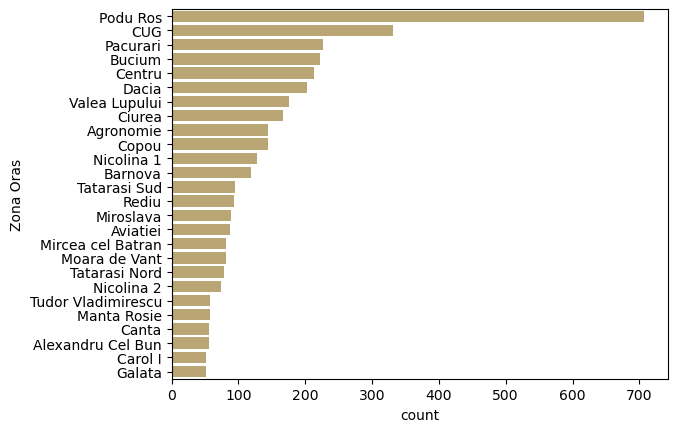

In [67]:
df= pd.DataFrame(new_vanzare_df['Zona Oras'].value_counts())
index_to_drop = df.index[df['count']<=50].to_list()
df = df.drop(index_to_drop)
sns.barplot(x='count', y = df.index, data= df, color="#C6A969")

Se observă că cele mai apartamente se află în Cartierele: Podu Roș, CUG, Păcurari.

<Axes: xlabel='Zona Oras 2', ylabel='Numar Etaj Bloc'>

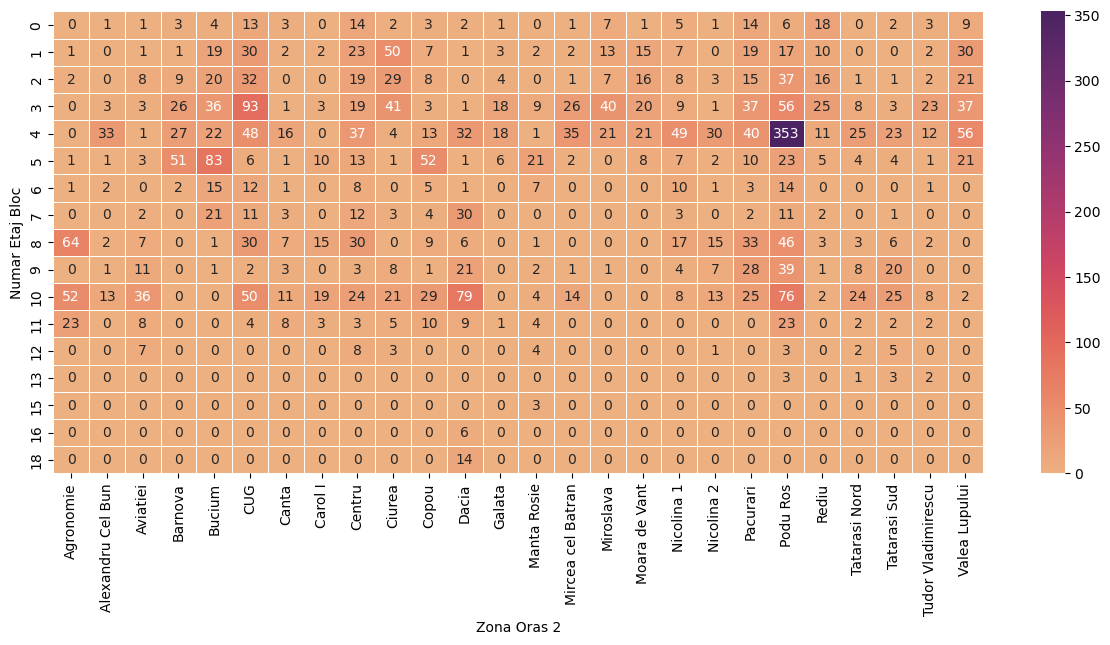

In [68]:
df = new_vanzare_df.groupby(['Zona Oras'], as_index=False)['Numar Etaj Bloc'].value_counts()
df['Zona Oras 2'] = df.apply(lambda dft: zona_oras_2(dft["Zona Oras"], df), axis=1)
df = df.drop('Zona Oras', axis=1)
index_to_drop = df.index[df["Zona Oras 2"]=="Alte Zone"].to_list()
df = df.drop(index_to_drop)
blocuri = (df.pivot(index="Numar Etaj Bloc", columns="Zona Oras 2", values="count"))
blocuri = blocuri.fillna(0)
blocuri = blocuri.astype('int')
f, ax = plt.subplots(figsize=(15,6))
sns.heatmap(blocuri, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="flare")

În observă că în general numărul de apartamente scoase la vânzare pe zona nu diferă așa mult în funcție de numărul de etaje ale blocului. Mai puțîn pentru Podu Roș unde există o cantitate foarte mare de apartamente în blocuri cu 4 etaje.

<Axes: xlabel='An rotunjit', ylabel='count'>

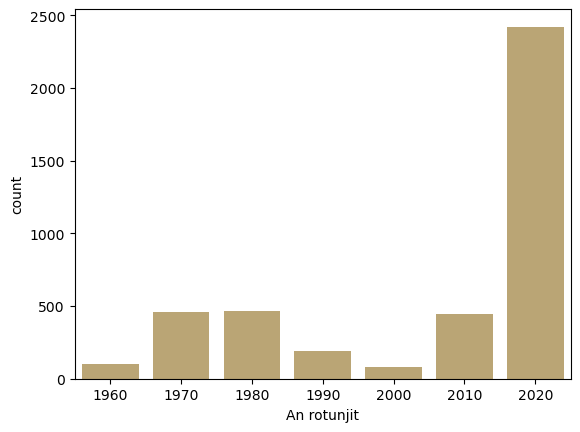

In [69]:
df = pd.DataFrame(new_vanzare_df['An rotunjit'].value_counts())
sns.barplot(x=df.index, y = 'count', data= df, color="#C6A969")

Fiind de așteptat, majoritatea intrărilor sunt în blocuri noi (construite după anul  2020, inclusiv).

Totuși, dacă ne uităm în ce an au fost finalizate lucrările raportate pe cartier se observă că în Podu Roș majoritatea sunt finalizate în anii 70-80.

<Axes: xlabel='Zona Oras 2', ylabel='An rotunjit'>

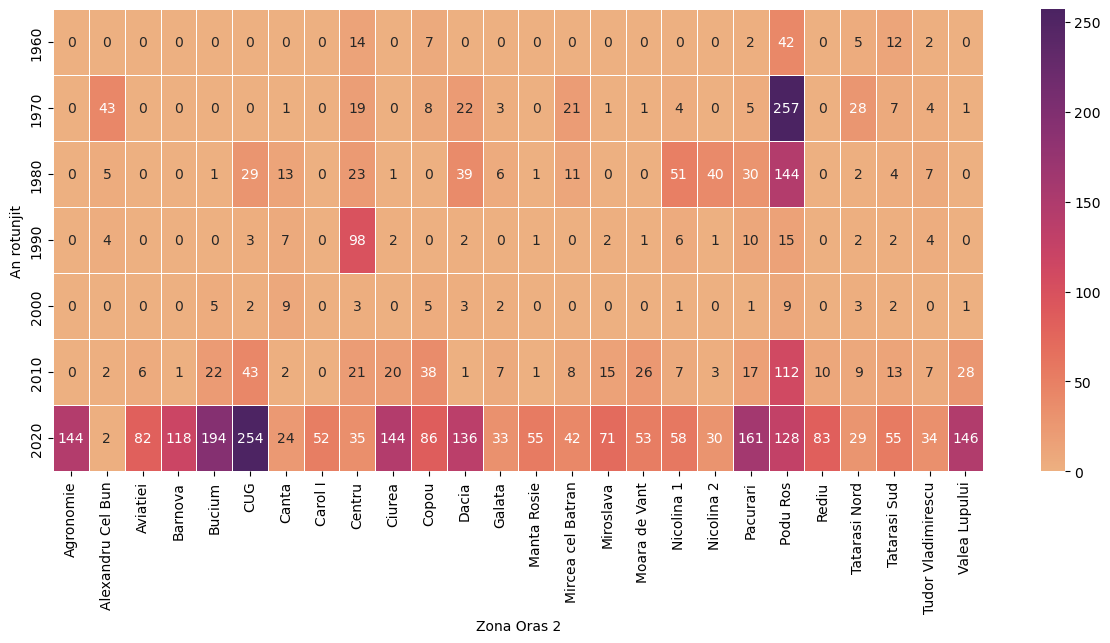

In [70]:
df = new_vanzare_df.groupby(['Zona Oras'], as_index=False)['An rotunjit'].value_counts()
df['Zona Oras 2'] = df.apply(lambda dft: zona_oras_2(dft["Zona Oras"], df), axis=1)
df = df.drop('Zona Oras', axis=1)
index_to_drop = df.index[df["Zona Oras 2"]=="Alte Zone"].to_list()
df = df.drop(index_to_drop)
blocuri = (df.pivot(index='An rotunjit', columns="Zona Oras 2", values="count"))
blocuri = blocuri.fillna(0)
blocuri = blocuri.astype('int')
f, ax = plt.subplots(figsize=(15,6))
sns.heatmap(blocuri, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="flare")

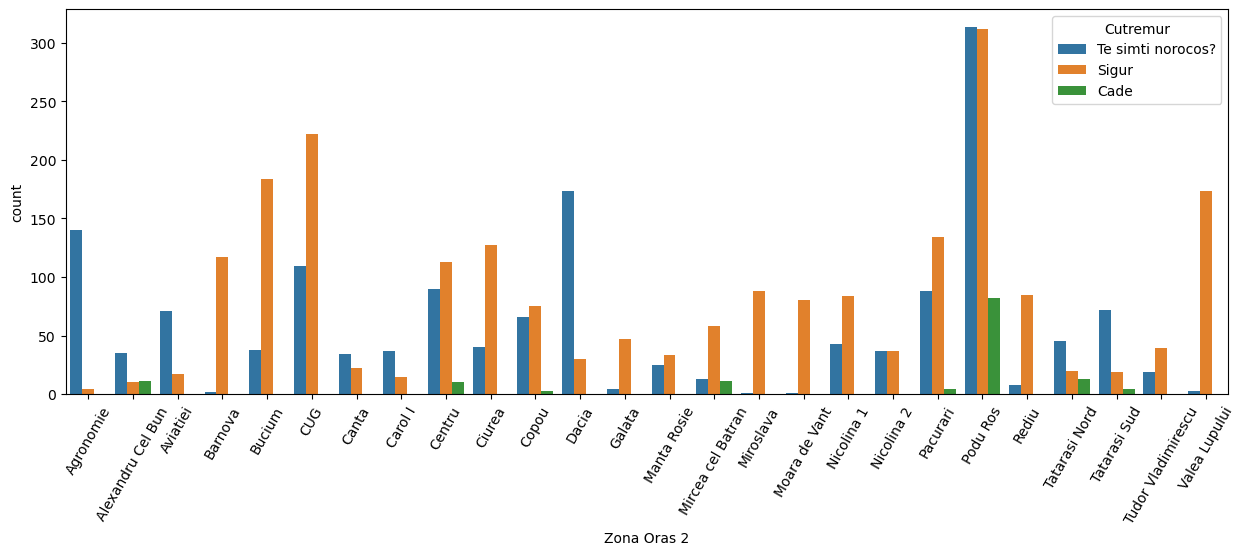

In [71]:
df = new_vanzare_df.groupby(['Zona Oras'], as_index=False)['Cutremur'].value_counts()
df['Zona Oras 2'] = df.apply(lambda dft: zona_oras_2(dft["Zona Oras"], df), axis=1)
df = df.drop('Zona Oras', axis=1)
index_to_drop = df.index[df["Zona Oras 2"]=="Alte Zone"].to_list()
df = df.drop(index_to_drop)
fig, ax = plt.subplots(figsize=(15,5))
g = sns.barplot(x='Zona Oras 2', y='count', hue='Cutremur', data=df, ax=ax)
ax.tick_params(axis='x', rotation=60)

Dacă ne uităm la ele "cum s-ar descurcă la un cutremur", majoritatea nu se încadrează în categoria "Cade", asta poate să fie si din cauza că majoritatea blocurilor sunt sub 5 etaje.

<h3>Acum am dori să vedem pt fiecae perioada care sunt cele mai "populare" niveluri de înălțime pentru blocuri.</h3>

<Axes: xlabel='An rotunjit', ylabel='Numar Etaj Bloc'>

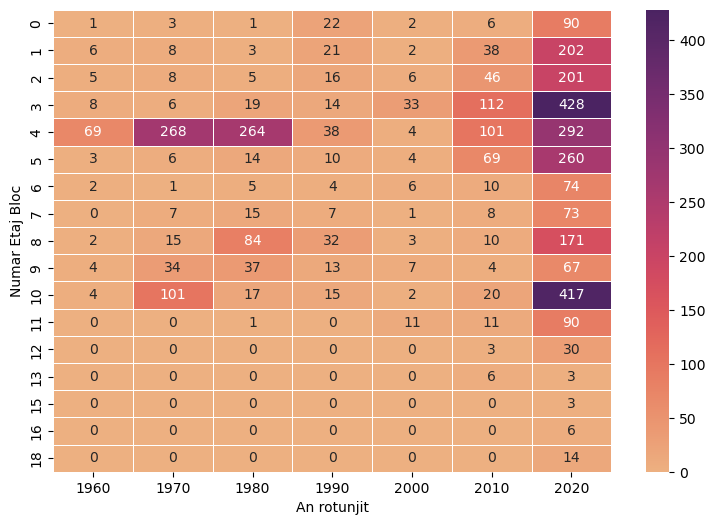

In [72]:
df = new_vanzare_df.groupby(['An rotunjit'], as_index=False)['Numar Etaj Bloc'].value_counts()
blocuri = (df.pivot(index="Numar Etaj Bloc", columns="An rotunjit", values="count"))
blocuri = blocuri.fillna(0)
blocuri = blocuri.astype('int')
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(blocuri, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="flare")

Se poate observă că pentru majoritea apartamentelor din perioada comunistă(înainte de 1990) ele provin din blocuri de 4 etaje, apoi 8 și 10.

Pentru blocurile noi(începând cu anii 2020) se pare că majoritatea vin din blocuri cu mai puțin de 6 etaje sau dintr-un bloc cu 10 etaje.

<Axes: xlabel='Numărul de camere', ylabel='Numar Etaj Bloc'>

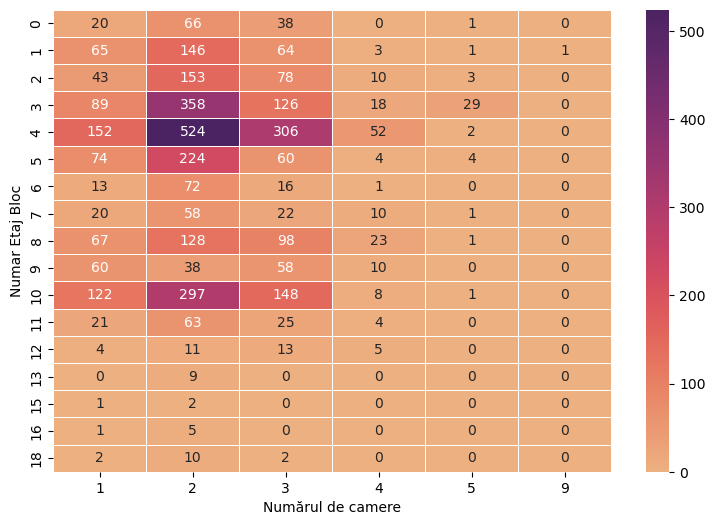

In [73]:
df = new_vanzare_df.groupby(['Numărul de camere'], as_index=False)['Numar Etaj Bloc'].value_counts()
apartamente = df.pivot(index='Numar Etaj Bloc', columns='Numărul de camere', values="count")
apartamente = apartamente.fillna(0)
apartamente = apartamente.astype('int')
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(apartamente, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="flare")

Se pare că nu contează nivelul de înălțime a blocului cele mai multe apartamente sunt de 2 camere.

<h3>Să ne uităm acuma asupra locului de parcare și a metodei de încălzire în funcție de perioada în care blocul a fost finalizat cât și a cartierului din care face parte.</h3>

<Axes: xlabel='Count', ylabel='An rotunjit'>

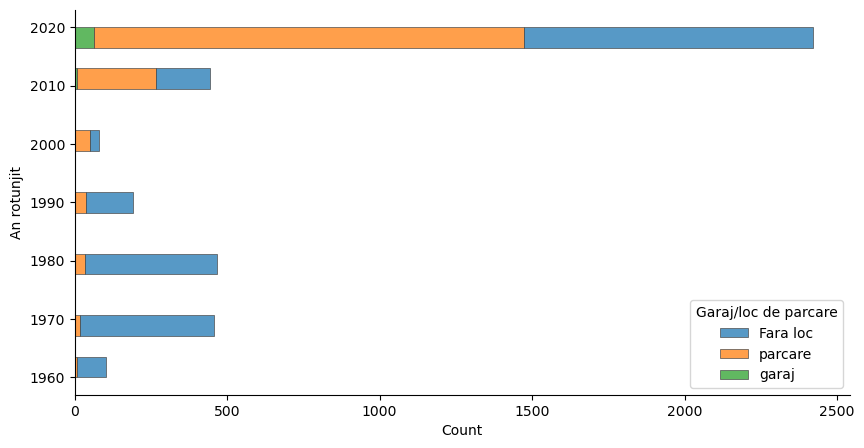

In [74]:
f, ax = plt.subplots(figsize=(10,5))
sns.despine(f)
sns.histplot(new_vanzare_df,
             y='An rotunjit',
             hue="Garaj/loc de parcare", 
             multiple="stack",
             edgecolor=".3",
             linewidth=.5)

Se poate observă că pentru majoritatea blocurilor mai vechi de 2000, ele nu un loc de parcare. Începând cu anii 2000 se poate vedea că apartamentele vin și cu loc de parcare.

Note: Am luat în calcul și apartamentele pentru care locul de parcare se cumpără separat.

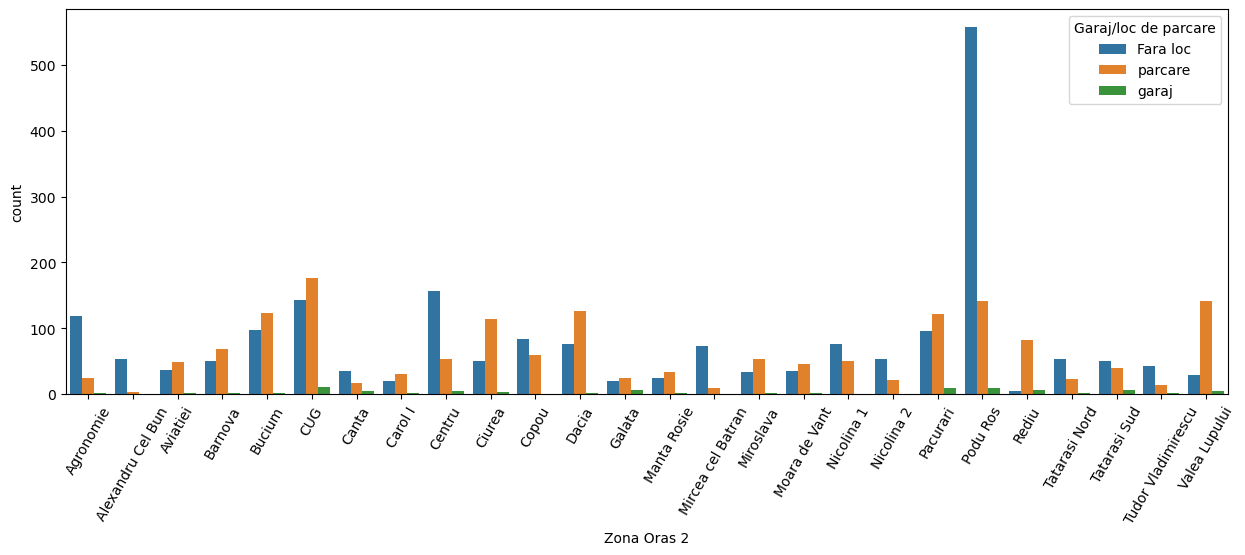

In [75]:
df = new_vanzare_df.groupby(['Zona Oras'], as_index=False)["Garaj/loc de parcare"].value_counts()
df['Zona Oras 2'] = df.apply(lambda dft: zona_oras_2(dft["Zona Oras"], df), axis=1)
df = df.drop('Zona Oras', axis=1)
index_to_drop = df.index[df["Zona Oras 2"]=="Alte Zone"].to_list()
df = df.drop(index_to_drop)
fig, ax = plt.subplots(figsize=(15,5))
g = sns.barplot(x='Zona Oras 2', y='count', hue="Garaj/loc de parcare", data=df, ax=ax)
ax.tick_params(axis='x', rotation=60)

Dacă ne uităm în raport cu zona, numărul apartamentelor cu loc de parcare este apropiat de numărul celor fără.

['Fara loc' 'parcare']


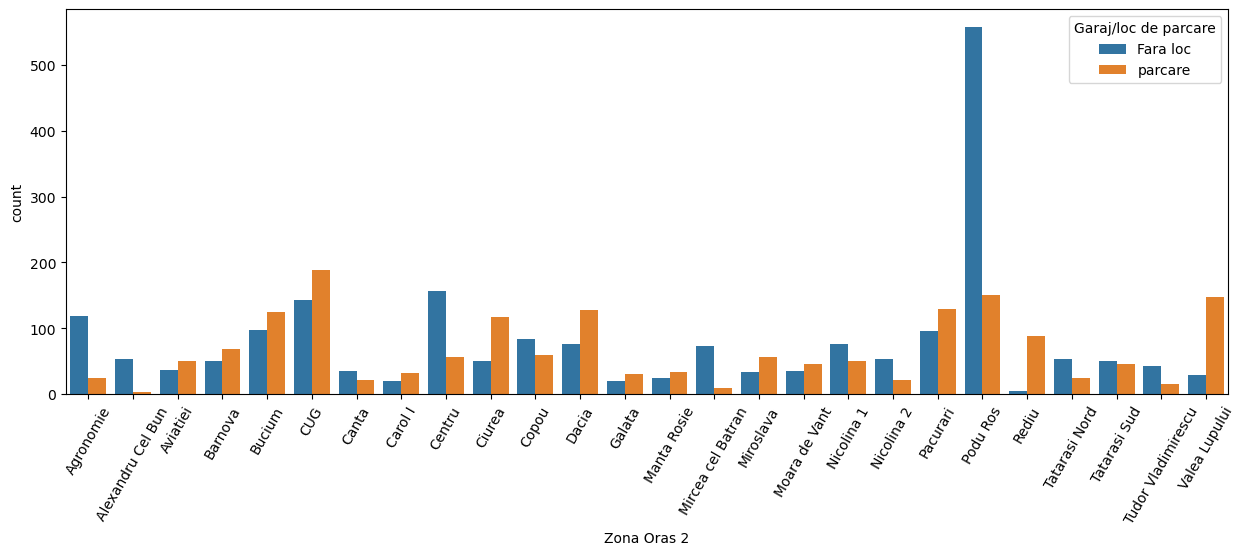

In [76]:
df = new_vanzare_df
df = df.replace("garaj", "parcare")
df = df.groupby(['Zona Oras'], as_index=False)["Garaj/loc de parcare"].value_counts()
print(df["Garaj/loc de parcare"].unique())
df['Zona Oras 2'] = df.apply(lambda dft: zona_oras_2(dft["Zona Oras"], df), axis=1)
df = df.drop('Zona Oras', axis=1)
index_to_drop = df.index[df["Zona Oras 2"]=="Alte Zone"].to_list()
df = df.drop(index_to_drop)
fig, ax = plt.subplots(figsize=(15,5))
g = sns.barplot(x='Zona Oras 2', y='count', hue="Garaj/loc de parcare", data=df, ax=ax)
ax.tick_params(axis='x', rotation=60)

<Axes: xlabel='Count', ylabel='An rotunjit'>

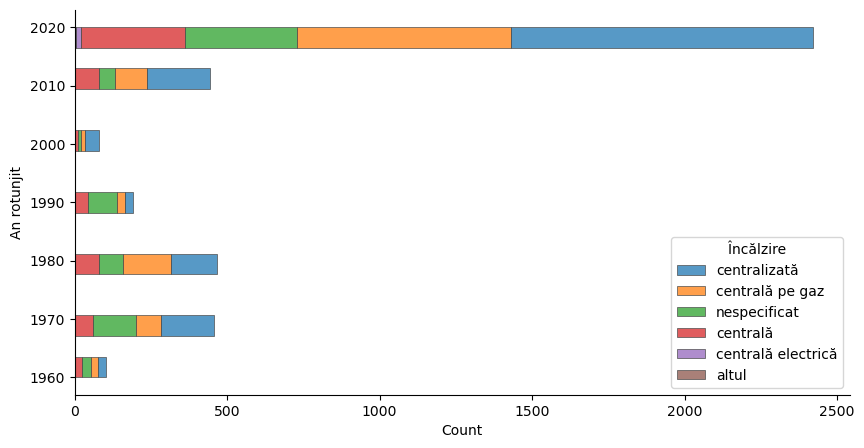

In [77]:
f, ax = plt.subplots(figsize=(10,5))
sns.despine(f)
sns.histplot(new_vanzare_df,
             y='An rotunjit',
             hue="Încălzire", 
             multiple="stack",
             edgecolor=".3",
             linewidth=.5)

Metodele  de încălzire predominante sunt încălzirea centralizată și cu ajutorul unei centrale pe gaz, acesta fiind valabil pentu fiecare interval de timp.

Note: Pare că tipul "centrală" se referă în special la centrale pe gaz.( din cauza numărului mic de centrale electrice).

<Axes: xlabel='Count', ylabel='An rotunjit'>

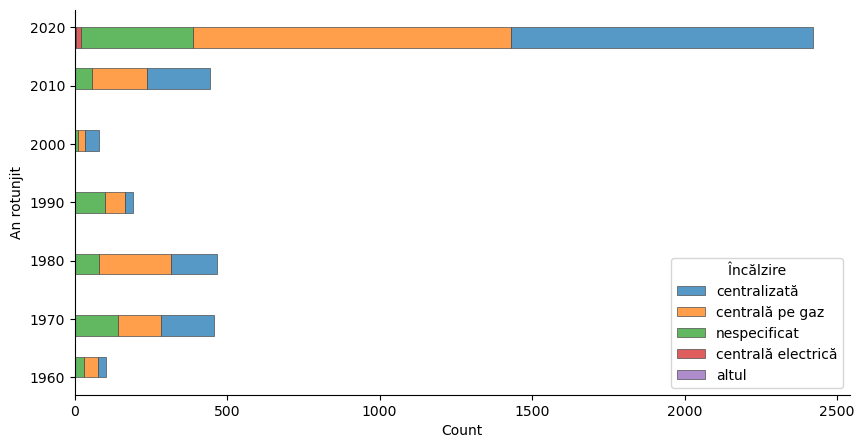

In [78]:
df = new_vanzare_df
df = df.replace("centrală", "centrală pe gaz")
f, ax = plt.subplots(figsize=(10,5))
sns.despine(f)
sns.histplot(df,
             y='An rotunjit',
             hue="Încălzire", 
             multiple="stack",
             edgecolor=".3",
             linewidth=.5)

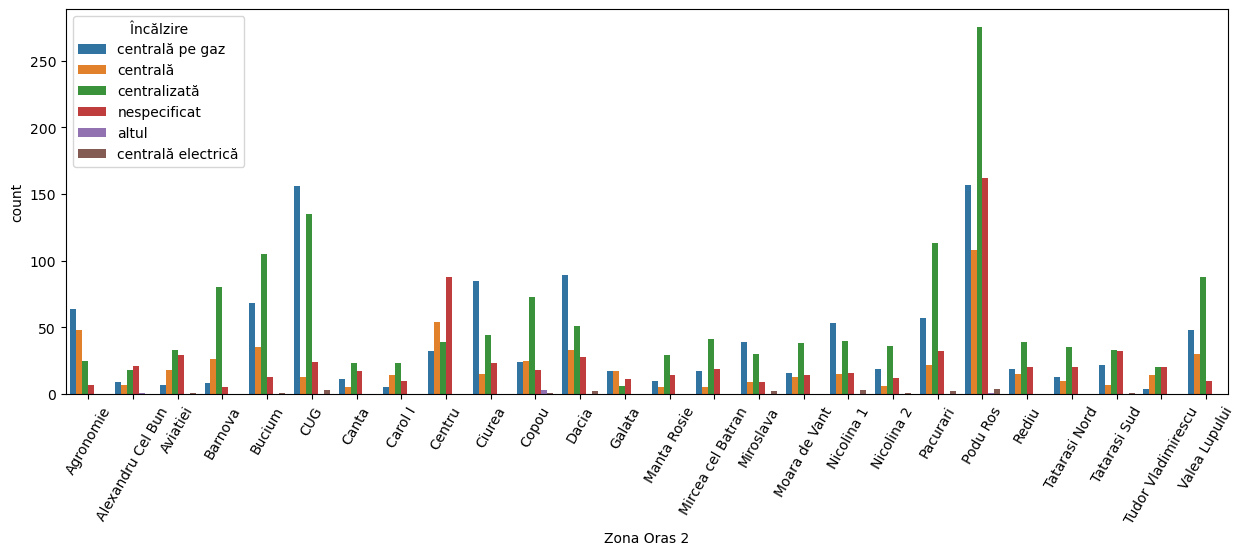

In [79]:
df = new_vanzare_df.groupby(['Zona Oras'], as_index=False)["Încălzire"].value_counts()
df['Zona Oras 2'] = df.apply(lambda dft: zona_oras_2(dft["Zona Oras"], df), axis=1)
df = df.drop('Zona Oras', axis=1)
index_to_drop = df.index[df["Zona Oras 2"]=="Alte Zone"].to_list()
df = df.drop(index_to_drop)
fig, ax = plt.subplots(figsize=(15,5))
g = sns.barplot(x='Zona Oras 2', y='count', hue="Încălzire", data=df, ax=ax)
ax.tick_params(axis='x', rotation=60)

Se pare că în general încălzirea unui apartament este realizat prin centrală pe gaz(dacă luăm în consideră că din cauza că centrale electrice sunt foarte rare, majoritatea oamenilor prin centrală se referă la centrală pe gaz) sau centralizat cam în toate zonele zonei metropolitane.

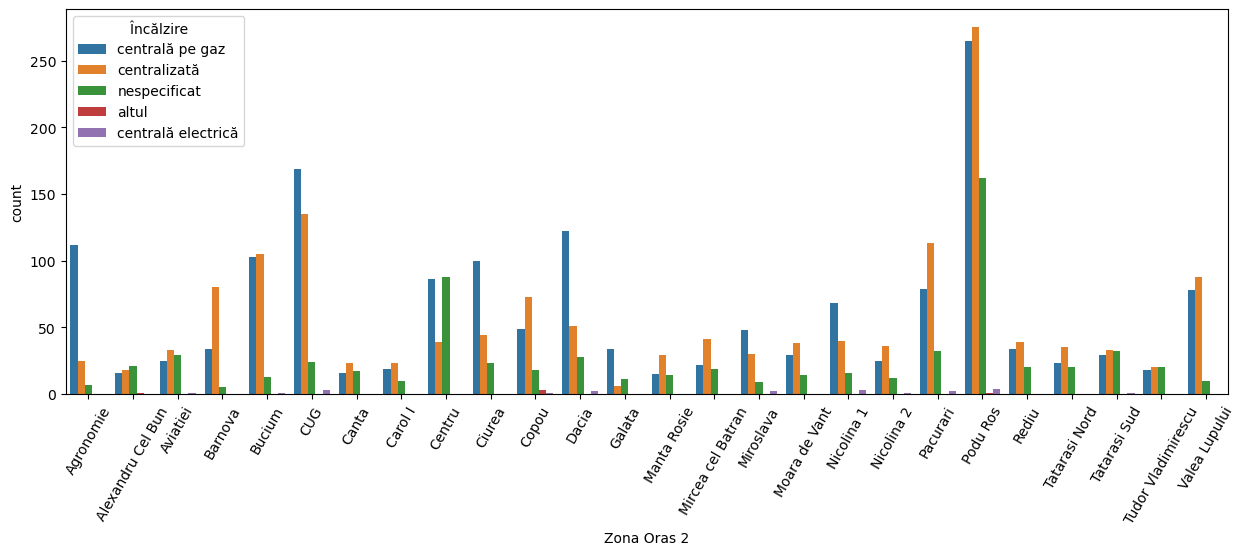

In [80]:
df = new_vanzare_df
df = df.replace("centrală", "centrală pe gaz")
df = df.groupby(['Zona Oras'], as_index=False)["Încălzire"].value_counts()
df['Zona Oras 2'] = df.apply(lambda dft: zona_oras_2(dft["Zona Oras"], df), axis=1)
df = df.drop('Zona Oras', axis=1)
index_to_drop = df.index[df["Zona Oras 2"]=="Alte Zone"].to_list()
df = df.drop(index_to_drop)
fig, ax = plt.subplots(figsize=(15,5))
g = sns.barplot(x='Zona Oras 2', y='count', hue="Încălzire", data=df, ax=ax)
ax.tick_params(axis='x', rotation=60)

<h3> Să vedem acum dacă există o corelație dintre preț/suprafață și anumite "caracteristi" ale apartamentului. </h3>

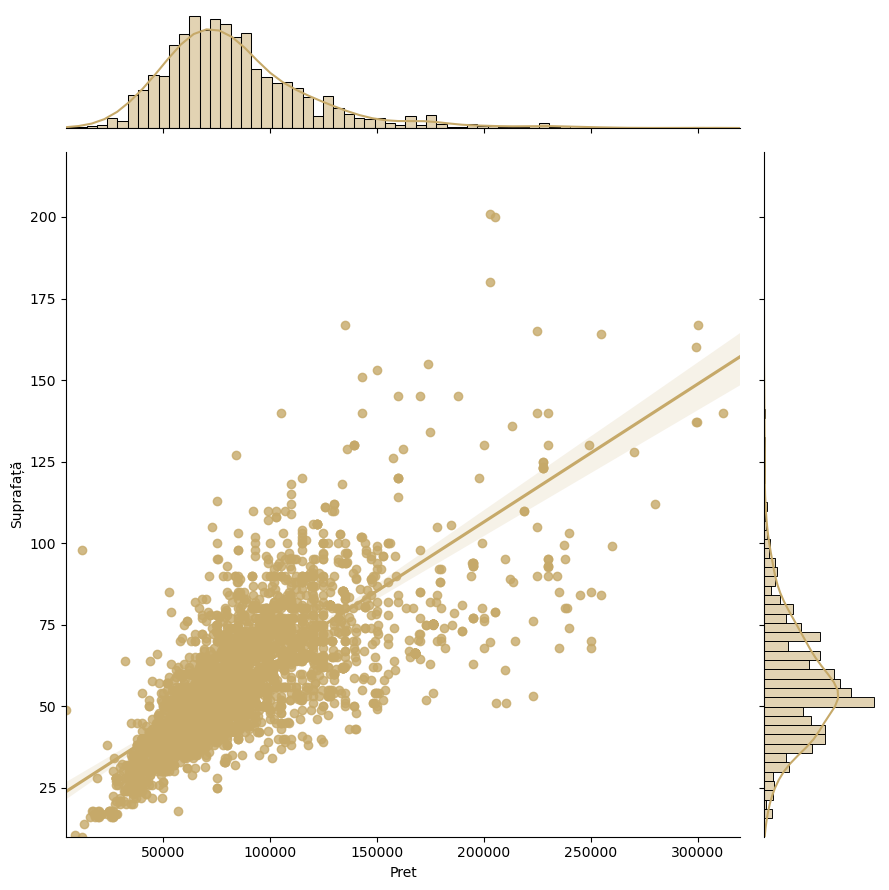

In [81]:
sns.jointplot(x='Pret', y='Suprafață',
              data=new_vanzare_df,
              kind='reg',
              color='#C6A969',
              height=9,
              ylim=(new_vanzare_df['Suprafață'].min(), 220),
              xlim=(new_vanzare_df['Pret'].min(),320000))

Se poate vedea clar că există o corelație dintre preț și suprafață (chiar dacă nu explică fiecare punct), o să pornim de la acest lucru.

[(10.0, 220.0), (4634.0, 320000.0)]

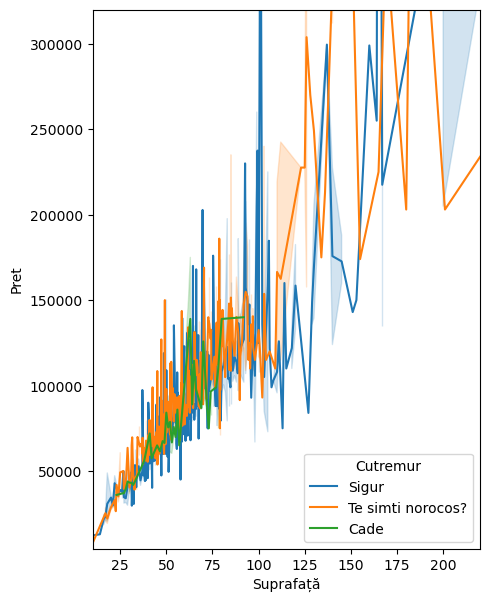

In [82]:
f, ax = plt.subplots(figsize=(5,7))
g = sns.lineplot(x="Suprafață",
                 y="Pret",
                 hue="Cutremur",
                 data=new_vanzare_df,
                 ax=ax)
g.set(xlim=(new_vanzare_df['Suprafață'].min(), 220),
              ylim=(new_vanzare_df['Pret'].min(),320000))

Din grafic  pare că efectele unui cutremur să afecteze prețul.

[(10.0, 220.0), (4634.0, 320000.0)]

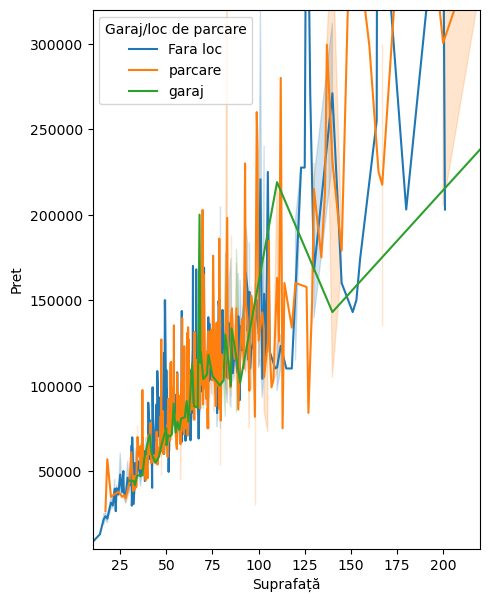

In [83]:
f, ax = plt.subplots(figsize=(5,7))
g = sns.lineplot(x="Suprafață",
                 y="Pret",
                 hue="Garaj/loc de parcare", 
                 data=new_vanzare_df,
                 ax=ax
            )
g.set(xlim=(new_vanzare_df['Suprafață'].min(), 220),
              ylim=(new_vanzare_df['Pret'].min(),320000)
     ,)

Din grafic nu pare că locul de parcare să afecteze prețul.

[(10.0, 220.0), (4634.0, 320000.0)]

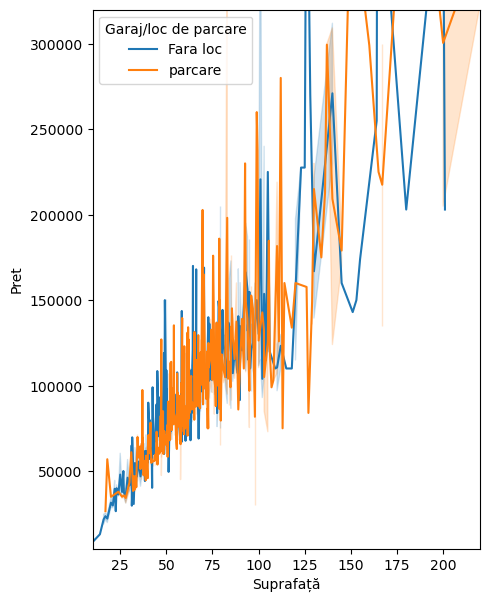

In [84]:
df = new_vanzare_df
df = df.replace("garaj", "parcare")
f, ax = plt.subplots(figsize=(5,7))
g = sns.lineplot(x="Suprafață",
                 y="Pret",
                 hue="Garaj/loc de parcare", 
                 data=df,
                 ax=ax
            )
g.set(xlim=(new_vanzare_df['Suprafață'].min(), 220),
              ylim=(new_vanzare_df['Pret'].min(),320000)
     ,)

[(10.0, 220.0), (4634.0, 320000.0)]

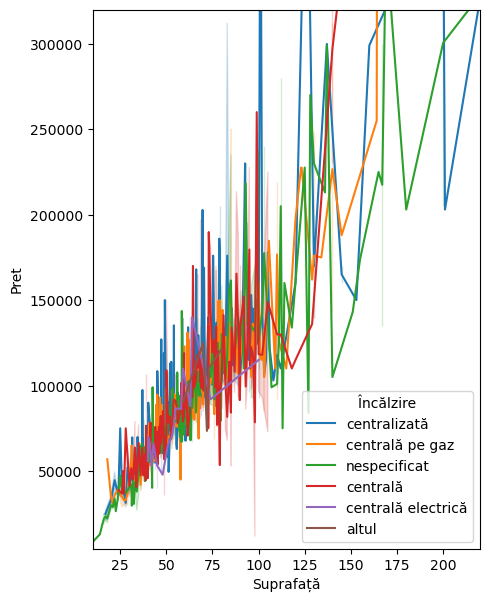

In [85]:
f, ax = plt.subplots(figsize=(5,7))
g = sns.lineplot(x="Suprafață",
                 y="Pret",
                 hue="Încălzire", 
                 data=new_vanzare_df,
                 ax=ax
            )
g.set(xlim=(new_vanzare_df['Suprafață'].min(), 220),
              ylim=(new_vanzare_df['Pret'].min(),320000)
     ,)

Din grafic nu pare că metodă de încălzire să afecteze prețul.

[(10.0, 220.0), (4634.0, 320000.0)]

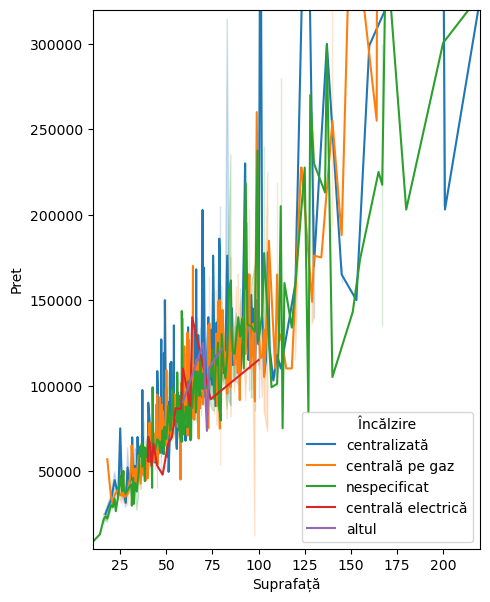

In [86]:
df = new_vanzare_df
df = df.replace("centrală", "centrală pe gaz")
f, ax = plt.subplots(figsize=(5,7))
g = sns.lineplot(x="Suprafață",
                 y="Pret",
                 hue="Încălzire", 
                 data=df,
                 ax=ax
            )
g.set(xlim=(new_vanzare_df['Suprafață'].min(), 220),
              ylim=(new_vanzare_df['Pret'].min(),320000)
     ,)

<h2> Analiză statistică </h2>

In [87]:
df = new_vanzare_df
df = df.replace('centrală', 'centrală pe gaz')
cross_tab = pd.crosstab(df['Pret'], df['Încălzire'], margins=True)
st.chi2_contingency(cross_tab)

Chi2ContingencyResult(statistic=6627.204305892288, pvalue=1.8276185809654235e-46, dof=5055, expected_freq=array([[1.20076849e-03, 3.90730067e-01, 5.04322767e-03, 4.17146974e-01,
        1.85878963e-01, 1.00000000e+00],
       [1.20076849e-03, 3.90730067e-01, 5.04322767e-03, 4.17146974e-01,
        1.85878963e-01, 1.00000000e+00],
       [1.20076849e-03, 3.90730067e-01, 5.04322767e-03, 4.17146974e-01,
        1.85878963e-01, 1.00000000e+00],
       ...,
       [1.20076849e-03, 3.90730067e-01, 5.04322767e-03, 4.17146974e-01,
        1.85878963e-01, 1.00000000e+00],
       [1.20076849e-03, 3.90730067e-01, 5.04322767e-03, 4.17146974e-01,
        1.85878963e-01, 1.00000000e+00],
       [5.00000000e+00, 1.62700000e+03, 2.10000000e+01, 1.73700000e+03,
        7.74000000e+02, 4.16400000e+03]]))

$\hspace{5cm}H_{0}=$ exista asociere intre variabile$\hspace{5cm}$$H_{1}=$ nu exista asociere intre variabile

$pvalue=1.8276185809654235e-46 < 0.05$ se accepta ipoteza nula

In [88]:
df = new_vanzare_df
df = df.replace('garaj', 'parcare')
cross_tab = pd.crosstab(df['Pret'], df['Garaj/loc de parcare'], margins=True)
st.chi2_contingency(cross_tab)

Chi2ContingencyResult(statistic=1599.7618569271501, pvalue=0.9999999999995886, dof=2022, expected_freq=array([[5.47310279e-01, 4.52689721e-01, 1.00000000e+00],
       [5.47310279e-01, 4.52689721e-01, 1.00000000e+00],
       [5.47310279e-01, 4.52689721e-01, 1.00000000e+00],
       ...,
       [5.47310279e-01, 4.52689721e-01, 1.00000000e+00],
       [5.47310279e-01, 4.52689721e-01, 1.00000000e+00],
       [2.27900000e+03, 1.88500000e+03, 4.16400000e+03]]))

$\hspace{5cm}H_{0}=$ exista asociere intre variabile$\hspace{5cm}$$H_{1}=$ nu exista asociere intre variabile

$pvalue=0.9999999999995886 > 0.05$ se refuza ipoteza nula

In [89]:
cross_tab = pd.crosstab(new_vanzare_df['Pret'], new_vanzare_df['Cutremur'], margins=True)
st.chi2_contingency(cross_tab)

Chi2ContingencyResult(statistic=2493.8229861151153, pvalue=0.9999999999999165, dof=3033, expected_freq=array([[3.41018252e-02, 5.74927954e-01, 3.90970221e-01, 1.00000000e+00],
       [3.41018252e-02, 5.74927954e-01, 3.90970221e-01, 1.00000000e+00],
       [3.41018252e-02, 5.74927954e-01, 3.90970221e-01, 1.00000000e+00],
       ...,
       [3.41018252e-02, 5.74927954e-01, 3.90970221e-01, 1.00000000e+00],
       [3.41018252e-02, 5.74927954e-01, 3.90970221e-01, 1.00000000e+00],
       [1.42000000e+02, 2.39400000e+03, 1.62800000e+03, 4.16400000e+03]]))

$\hspace{5cm}H_{0}=$ exista asociere intre variabile$\hspace{5cm}$$H_{1}=$ nu exista asociere intre variabile

$pvalue=0.9999999999999165 > 0.05$ se respinge  ipoteza nula

In [90]:
df = new_vanzare_df
df = df.replace('centrală', 'centrală pe gaz')
sample_from_df = df.sample(20)
valori_asteptate = np.array([8, 8, 4])
valori_observate = sample_from_df['Încălzire'].value_counts()
st.chisquare(valori_observate, f_exp=valori_asteptate)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (3,).

$\hspace{5cm}H_{0}=$ exista concordanta intre variabile$\hspace{5cm}$$H_{1}=$ nu exista concordanta intre variabile

$pvalue=0.5352614285189903 > 0.05$ se respinge ipoteza nula

<h2>Estimarea si testarea mediilor </h2>

In [ ]:
pret = new_vanzare_df['Pret']
f'Confidence interval for Pret {sms.DescrStatsW(pret).tconfint_mean()}'

In [ ]:
df = new_vanzare_df
df = df.replace('centrală', 'centrală pe gaz')
centralizat = df[df['Încălzire'] == 'centralizată']
centrala_gaz = df[df['Încălzire'] == 'centrală pe gaz']
st.ttest_ind(centralizat['Pret'], centrala_gaz['Pret'])

In [ ]:
st.ttest_ind(centralizat['Pret'], centrala_gaz['Pret'], equal_var=False)

In [ ]:
df = new_vanzare_df
doua_camere = df[df['Numărul de camere'] == 2]
trei_camere = df[df['Numărul de camere'] == 3]
st.ttest_ind(doua_camere['Pret'],trei_camere['Pret'])

In [ ]:
st.ttest_ind(doua_camere['Pret'],trei_camere['Pret'], equal_var=False)

In [ ]:
model = ols('Pret ~ Suprafață', data=new_vanzare_df).fit()

In [ ]:
sm.stats.anova_lm(model, type=2)

<h2>Analiza de corelatie</h2>

In [ ]:
st.pearsonr(new_vanzare_df['Pret'], new_vanzare_df['Suprafață'])

In [ ]:
x = sm.add_constant(new_vanzare_df['Suprafață'])
model = sm.OLS(new_vanzare_df['Pret'], x)
result = model.fit()
result.summary()


In [ ]:
df = new_vanzare_df
df = df.replace(['Sigur', 'Te simti norocos?', 'Cade'],[0, 1, 2])
x_multiplu = sm.add_constant(df[['Suprafață', "Pret"]])
y = df['Cutremur']
model_multiplu = sm.OLS(y, x_multiplu)
result_model = model_multiplu.fit()
result_model.summary()

In [ ]:
df = new_vanzare_df
df = df.replace(['Fara loc', 'parcare', 'garaj'],[0, 1, 1])
x_multiplu = sm.add_constant(df[['Suprafață', "Pret"]])
y = df['Garaj/loc de parcare']
model_multiplu = sm.OLS(y, x_multiplu)
result_model = model_multiplu.fit()
result_model.summary()